# Root Cause Discovery + Lasso

Here for a known "root cause gene", lets run a Lasso regression to filter down the number of features, before running Root Cause Discovery algorithm

+ After processing, we obtained 2 datasets
    1. "Interventional data": there are 32 samples for which we have ground truth data. Each row is a gene and each column is a sample. 
    2. "observational data": these are a few hundred samples for which we did not do any intervention. Each row is a gene and each column is a sample.
+ The main idea is that an intervention supposedly caused a disturbance in gene expression, so we can compare the data of intervention to baseline (i.e. observational data), and try to which gene is most differentially expressed

In [1]:
# using Pkg
# Pkg.update("RootCauseDiscovery")

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using ProgressMeter
using LinearAlgebra
BLAS.set_num_threads(1)

using Plots
gr(fmt=:png)

# import RootCauseDiscovery.zscore
# import RootCauseDiscovery.compute_permutations
# import RootCauseDiscovery.root_cause_discovery
# import RootCauseDiscovery.find_largest
# import RootCauseDiscovery.find_second_largest

# using Statistics
# import StatsBase.cov2cor
# using GLMNet
# using CovarianceEstimation
# using LinearAlgebra
# using Plots
# gr(fmt=:png)
# include("/home/users/bbchu/RootCauseDiscovery/utilities.jl")

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, 
        total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

"""
Given a patient, we compute its Z-score rank, and then try to refine
its rank via the RCD method. Note: if the root cause was not used as
the response in lasso regression, its refined rank will be `Inf`
"""
function refine_z_score_rank(
        jld2_file::String,
        patient_id::AbstractString,
        ground_truth::DataFrame,
        Xobs::AbstractMatrix,
        Xint::AbstractMatrix; #cv or largest_support
        max_acceptable_zscore = 1.5,
        verbose::Bool=true
    )
#     jld2_file = "/scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/$(lasso_method)/$(patient_id).jld2"
    results = JLD2.load(jld2_file, "results")
    y_indices = JLD2.load(jld2_file, "y_indices")

    # compute z scores
    Xint_sample = Xint[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), :]
    z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec

    # compute root cause index
    root_cause_idx = ground_truth[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
    if root_cause_idx ∉ y_indices
        verbose && println("The root cause was not chosen as a y for lasso")
        return Inf # return Inf when the root cause idx was not chosen as a y for lasso
    end

    # other needed quantities
    root_cause_zscore = z[root_cause_idx]
    root_cause_zscore_rank = count(x -> x > root_cause_zscore, z[y_indices])
    row_of_rootcause_in_result = findfirst(x -> x == root_cause_idx, y_indices)

    # for each gene w/ z score > 1.5, check its permutation table
    # to see if desired pattern exist
    matched = falses(length(results)) # length(matched) == length(results) == length(y_indices) 
    for (i, result) in enumerate(results)
        row = findlast(x -> x > max_acceptable_zscore, result[:, 6])
        if !isnothing(row)
            if result[row, 5] == result[row, 7]
                matched[i] = true
            end
        end
    end

    # calculate the refined rank for root cause
    root_cause_matched = matched[row_of_rootcause_in_result]
    if root_cause_matched
        # for all matching patterns, count how many have z scores
        # larger than the root cause
        counter = 0
        for (i, yi) in enumerate(y_indices)
            if (matched[i] == true) && (z[yi] > root_cause_zscore)
                counter += 1
            end
        end
        rk = counter
    else
        # if root cause index did not have desired matching pattern,
        # then if there's a matched variable, or the variable has larger Z score,
        # the variable will be ranked before the root cause
        counter = 0
        for (i, yi) in enumerate(y_indices)
            if (matched[i] == true) || (z[yi] > root_cause_zscore)
                counter += 1
            end
        end
        rk = counter
    end
    return rk
end


"""
same as refine_z_score_rank, except when there is a matching pattern, rather 
than using the Z score to rank them, we use the RCD ratio. The advantage of
the ranking with refine_z_score_rank is that a "matched" pattern will always
result in rank improvement. But it does not utilize the ratio of the 
larget - secondest cholesky score
"""
function refine_z_score_rank2(
        jld2_file::String,
        patient_id::AbstractString,
        ground_truth::DataFrame,
        Xobs::AbstractMatrix,
        Xint::AbstractMatrix; #cv or largest_support
        max_acceptable_zscore = 1.5,
        verbose::Bool=true
    )
#     jld2_file = "/scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/$(lasso_method)/$(patient_id).jld2"
    results = JLD2.load(jld2_file, "results")
    y_indices = JLD2.load(jld2_file, "y_indices")

    # compute z scores
    Xint_sample = Xint[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), :]
    z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec

    # compute root cause index
    root_cause_idx = ground_truth[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
    if root_cause_idx ∉ y_indices
        verbose && println("The root cause was not chosen as a y for lasso")
        return Inf # return Inf when the root cause idx was not chosen as a y for lasso
    end

    # other needed quantities
    root_cause_zscore = z[root_cause_idx]
    root_cause_zscore_rank = count(x -> x > root_cause_zscore, z[y_indices])
    row_of_rootcause_in_result = findfirst(x -> x == root_cause_idx, y_indices)

    # for each gene w/ z score > 1.5, check its permutation table
    # to see if desired pattern exist
    matched = falses(length(results)) # length(matched) == length(results) == length(y_indices) 
    matched_results_ratio = zeros(length(results))
    for (i, result) in enumerate(results)
        row = findlast(x -> x > max_acceptable_zscore, result[:, 6])
        if !isnothing(row)
            if result[row, 5] == result[row, 7]
                matched[i] = true
                matched_results_ratio[i] = result[row, 4]
            end
        end
    end

    # calculate the refined rank for root cause
    root_cause_matched = matched[row_of_rootcause_in_result]
    if root_cause_matched
        # for all matching patterns, check how many ratios are larger
        # than the root cause ratio
        root_cause_ratio = matched_results_ratio[row_of_rootcause_in_result]
        rk = count(x -> x > root_cause_ratio, matched_results_ratio)
    else
        println("no match")
        # if root cause index did not have desired matching pattern,
        # then if there's a matched variable, or the variable has larger Z score,
        # the variable will be ranked before the root cause
        counter = 0
        for (i, yi) in enumerate(y_indices)
            if (matched[i] == true) || (z[yi] > root_cause_zscore)
                counter += 1
            end
        end
        rk = counter
    end
    return rk
end

function make_plot(
        Z_score_rank::AbstractVector, 
        RCD_rank::AbstractVector, 
        patient_name::AbstractVector;
        plot1_ymax = 5500,
        plot2_ymin = -2500,
        plot2_ymax = 2500,
        title1 = "Root cause rank (Z-score vs Cholesky score)",
        title2 = "Original Z score rank - refined Z score rank"
    )
    # sort by diff in Z scores
    Z_score_diff = Z_score_rank - RCD_rank
    perm = sortperm(Z_score_diff)

    #
    # plot 1
    #
    plt1 = scatter(
        1:length(patient_name), 
        Z_score_rank[perm], 
        ylabel="rank", 
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        label = "Original z-score rank",
        title = title1,
        legend=:top,
        dpi=300,
        ylim=(0, plot1_ymax)
    )
    scatter!(plt1, 1:length(patient_name), RCD_rank[perm], label="Refined Z-score rank")

    #
    # plot 2
    #
    palettes = theme_palette(:auto)
    my_colors = []
    for i in eachindex(Z_score_diff)
        if isinf(Z_score_diff[i])
            push!(my_colors, :black)
            Z_score_diff[i] = plot2_ymin
        elseif Z_score_diff[i] > 0
            push!(my_colors, palettes[1])
        elseif Z_score_diff[i] == 0
            push!(my_colors, palettes[3])
        else
            push!(my_colors, palettes[2])
        end
    end

    # make plot
    plt2 = scatter(
        1:length(patient_name_success), 
        Z_score_diff[perm],
        title=title2, 
        ylabel="Rank difference",
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        ylim=(plot2_ymin, plot2_ymax),
        label = nothing,
        legend=:outerbottom,
        color=my_colors[perm],
        dpi=300,
    )
    hline!(plt2, [0], color=:black, linestyle=:dash, label=nothing)

    #
    # combine plots
    #
    return plot(plt1, plt2, layout = (2, 1), size=(800, 600))
end

make_plot (generic function with 1 method)

## Read processed data
First, read in data and log (base 2) transform them

In [29]:
low_count = 10
threshold = 0.05
dir = "/scratch/users/bbchu/RootCauseDiscovery/5.11.2024/data"

# this example succeeded for all patients
# low_count = 5
# threshold = 0.1
# dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.31.2024/data"

# read processed data
isdir(dir) || mkpath(dir)
trainsform_int_file = joinpath(dir, "transform_int")
transform_obs_file = joinpath(dir, "transform_obs")
ground_truth_file = joinpath(dir, "ground_truth")

if !(isfile(trainsform_int_file) && isfile(transform_obs_file) && isfile(ground_truth_file))
    # process raw data & save
    transform_int, transform_obs, ground_truth = QC_gene_expression_data(;
        low_count = low_count, threshold = threshold)
    CSV.write(trainsform_int_file, transform_int)
    CSV.write(transform_obs_file, transform_obs)
    CSV.write(ground_truth_file, ground_truth)
else
    transform_int = CSV.read(trainsform_int_file, DataFrame)
    transform_obs = CSV.read(transform_obs_file, DataFrame)
    ground_truth = CSV.read(ground_truth_file, DataFrame)
end

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

32×20687 transpose(::Matrix{Float64}) with eltype Float64:
 7.16651  7.52801  6.1614   5.76269  6.7147   …  4.24718   0.879887   5.86805
 7.29211  7.49392  5.7366   6.7872   6.83208     3.83948  -0.0317197  6.13789
 7.12903  7.71128  6.3046   5.84561  8.27485     4.56914  -0.350836   6.03098
 7.33725  7.58473  5.64158  5.67419  7.64089     4.20429   0.443085   5.81372
 7.32142  7.656    5.9637   5.72339  7.54602     4.3866   -0.0907366  6.2372
 7.96307  7.62904  6.31404  5.61436  7.65195  …  4.83569   0.587193   5.78292
 6.82785  7.12678  5.88636  5.76042  6.67355     4.58242   0.513396   5.41867
 7.39197  6.96249  5.91995  5.20811  7.54773     4.37331   1.74864    5.50518
 6.97241  7.24299  5.9      6.67716  6.16148     4.19093   0.0477996  5.9586
 6.68242  7.16005  5.76272  6.28711  5.6585      4.20968   0.0825506  5.74551
 7.25564  7.49943  5.88157  6.38944  7.68837  …  4.18839  -0.277521   6.38689
 7.24973  7.44043  6.17925  6.44836  7.89973     4.41432   0.434643   5.88568
 6.9657

## Test run Root Cause Discovery

In [3]:
# parameters for current run
patient_id = "R28774" # "R62943"
y_idx_z_threshold = 20.0
method = "largest_support"

# run main alg
Random.seed!(2024)
@time results, y_indices = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=2
);

# save result in jld2 format
# outfile = "/scratch/users/bbchu/RootCauseDiscovery/result_3.18.2024/$(patient_id).jld2"
# save(outfile, Dict("results"=>results, "y_indices"=>y_indices))

Trying 4 y_idx
Lasso found 295 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


Lasso found 421 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


Lasso found 456 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


Lasso found 389 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


319.263326 seconds (16.76 M allocations: 175.838 GiB, 1.17% gc time, 3.97% compilation time)


## Fast simulation to check whether the true root cause will have better ranking than z-score using our method
- Treat root cause as response 
- We want to see a matched pattern in column 5 and 7 for the last row

In [3]:
# lasso 
Random.seed!(2024)
patient_id = "R77611" #  "R80346", "R58859", "R28774", "R62943", "R20754", "R36605", "R60537" works
root_cause_idx = ground_truth[
    findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
method = "largest_support"
Xobs_new, Xint_sample_new, root_cause_idx_new = 
    RootCauseDiscovery.reduce_genes(patient_id, 
    root_cause_idx, Xobs, Xint, ground_truth, method)

# run main alg
@time result = RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new, Xint_sample_new, nshuffles=2)
result

Lasso found 243 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


 20.440196 seconds (10.74 M allocations: 5.405 GiB, 2.35% gc time, 56.59% compilation time)


1420×7 Matrix{Float64}:
 22.6786  21.7266    0.952006   0.0438176  244.0  8.48879  244.0
 22.2947  19.8342    2.46054    0.124056   244.0  8.48879  244.0
 22.8923  19.3462    3.54611    0.183298   244.0  8.48879  244.0
 22.2293  18.428     3.80137    0.206283   244.0  8.48879  244.0
 22.6379  18.6825    3.95545    0.21172    244.0  8.48879  244.0
 23.1106  18.1308    4.97979    0.274659   244.0  8.48879  244.0
 23.5563  18.0351    5.52116    0.306134   244.0  8.48879  244.0
 24.8258  18.903     5.92284    0.313328   244.0  8.48879  244.0
 24.5357  18.6027    5.93297    0.31893    244.0  8.48879  244.0
 25.1762  18.6027    6.57347    0.353361   244.0  8.48879  244.0
 27.4445  19.9978    7.44669    0.372375   244.0  8.48879  244.0
 29.7903  21.5069    8.28337    0.38515    244.0  8.48879  244.0
 25.9249  18.6914    7.23358    0.387001   244.0  8.48879  244.0
  ⋮                                               ⋮        
 61.7585   5.71088  56.0476     9.81418    244.0  8.48879  244.0
 61.47

## Simulation to check why the gene with largest Z-score still produce the matched pattern (not desired)

In [3]:
# lasso by treating the true root cause as response
Random.seed!(2024)
patient_id = "R77611" #  "R80346", "R58859", "R28774", "R62943", "R20754", "R36605", "R60537" works
root_cause_idx = ground_truth[
    findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
method = "largest_support"
Xobs_new, Xint_sample_new, selected_idx_rootcause = 
    RootCauseDiscovery.reduce_genes(patient_id, 
    root_cause_idx, Xobs, Xint, ground_truth, method)

# run main alg with correct root cause
@time result = RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new, Xint_sample_new, nshuffles=2)
result

Lasso found 243 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


 19.035877 seconds (10.74 M allocations: 5.405 GiB, 2.26% gc time, 56.37% compilation time)


1420×7 Matrix{Float64}:
 22.6786  21.7266    0.952006   0.0438176  244.0  8.48879  244.0
 22.2947  19.8342    2.46054    0.124056   244.0  8.48879  244.0
 22.8923  19.3462    3.54611    0.183298   244.0  8.48879  244.0
 22.2293  18.428     3.80137    0.206283   244.0  8.48879  244.0
 22.6379  18.6825    3.95545    0.21172    244.0  8.48879  244.0
 23.1106  18.1308    4.97979    0.274659   244.0  8.48879  244.0
 23.5563  18.0351    5.52116    0.306134   244.0  8.48879  244.0
 24.8258  18.903     5.92284    0.313328   244.0  8.48879  244.0
 24.5357  18.6027    5.93297    0.31893    244.0  8.48879  244.0
 25.1762  18.6027    6.57347    0.353361   244.0  8.48879  244.0
 27.4445  19.9978    7.44669    0.372375   244.0  8.48879  244.0
 29.7903  21.5069    8.28337    0.38515    244.0  8.48879  244.0
 25.9249  18.6914    7.23358    0.387001   244.0  8.48879  244.0
  ⋮                                               ⋮        
 61.7585   5.71088  56.0476     9.81418    244.0  8.48879  244.0
 61.47

In [6]:
# did feature with largest Z score get included? (ans: no)
i = findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"])
Xint_sample = Xint[i, :]
z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec
max_z, max_z_idx = findmax(z)
@show max_z_idx in selected_idx_rootcause

# include max_z_idx in selected_idx_rootcause
selected_idx_new = [max_z_idx; selected_idx_rootcause]
Xobs_new2 = Xobs[:, selected_idx_new]
Xint_sample_new2 = Xint[i, selected_idx_new]

# run main alg
@time result = RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new2, Xint_sample_new2, nshuffles=2)
result

max_z_idx in selected_idx_rootcause = false


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  9.292675 seconds (82.75 k allocations: 4.898 GiB, 1.26% gc time)


1470×7 Matrix{Float64}:
 25.1273  24.5371    0.590204  0.0240535  245.0  8.48879  245.0
 22.6393  21.9273    0.71202   0.0324719  245.0  8.48879  245.0
 23.4205  22.5932    0.827315  0.0366178   56.0  1.00846  245.0
 23.1466  22.1652    0.981423  0.0442777  245.0  8.48879  245.0
 24.735   21.7658    2.96916   0.136414   245.0  8.48879  245.0
 22.0517  19.2532    2.79851   0.145353   245.0  8.48879  245.0
 23.5845  20.4717    3.11282   0.152055   245.0  8.48879  245.0
 23.3954  20.2557    3.1397    0.155004   245.0  8.48879  245.0
 22.7773  19.4053    3.37201   0.173767   245.0  8.48879  245.0
 23.9138  20.2102    3.70364   0.183256   245.0  8.48879  245.0
 24.291   20.4773    3.81368   0.186239   245.0  8.48879  245.0
 26.2549  22.0544    4.20047   0.19046    245.0  8.48879  245.0
 22.48    18.8344    3.64561   0.193562   245.0  8.48879  245.0
  ⋮                                              ⋮        
 61.6318   9.07511  52.5567    5.7913     245.0  8.48879  245.0
 61.6537   9.05862  5

In [8]:
# what if we use largest Z-score variable as response?
max_z, max_z_idx = findmax(z)

# lasso to reduce dimension
method = "largest_support"
Xobs_new, Xint_sample_new, selected_idx_maxZ = 
    RootCauseDiscovery.reduce_genes(patient_id, 
    max_z_idx, Xobs, Xint, ground_truth, method)

# run alg with max Z as response
@time result = 
    RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new, Xint_sample_new, nshuffles=2)

Lasso found 400 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


 53.706409 seconds (199.03 k allocations: 33.240 GiB, 0.88% gc time)


2506×7 Matrix{Float64}:
 7.11356  4.6751   2.43846  0.521585  401.0  25.6282  401.0
 8.03009  5.19712  2.83297  0.545104  401.0  25.6282  401.0
 7.09811  4.49582  2.60229  0.578824  401.0  25.6282  401.0
 7.66446  4.83571  2.82875  0.584972  401.0  25.6282  401.0
 7.4917   4.6751   2.8166   0.602469  401.0  25.6282  401.0
 8.38803  5.20644  3.18159  0.611088  401.0  25.6282  401.0
 7.85571  4.85561  3.0001   0.617862  401.0  25.6282  401.0
 8.38365  5.17107  3.21258  0.621261  401.0  25.6282  401.0
 7.70948  4.74825  2.96123  0.623648  401.0  25.6282  401.0
 7.59751  4.6751   2.92241  0.625102  401.0  25.6282  401.0
 8.01655  4.93256  3.08399  0.625232  401.0  25.6282  401.0
 7.50691  4.59537  2.91153  0.633579  401.0  25.6282  401.0
 7.62187  4.65833  2.96354  0.63618   401.0  25.6282  401.0
 ⋮                                            ⋮       
 8.71836  3.31455  5.40381  1.63033   401.0  25.6282  401.0
 9.63638  3.66248  5.9739   1.63111   401.0  25.6282  401.0
 9.09428  3.44304  5.

In [9]:
# check if root_cause_idx is selected
@show root_cause_idx ∈ selected_idx_maxZ

# run main alg with by including root_cause_idx in selected_idx
selected_idx_new = [root_cause_idx; selected_idx_maxZ]
Xobs_new3 = Xobs[:, selected_idx_new]
Xint_sample_new3 = Xint[i, selected_idx_new]

# run alg with lasso indices selected by max_Z + root cause idx
@time result_including_root_cause = 
    RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new3, Xint_sample_new3, nshuffles=2)

root_cause_idx ∈ selected_idx_maxZ = false


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


 61.703273 seconds (202.90 k allocations: 34.040 GiB, 1.01% gc time)


2556×7 Matrix{Float64}:
 7.18833  6.89129  0.297047  0.0431047  402.0  25.6282  402.0
 7.29421  6.85111  0.443106  0.0646765  402.0  25.6282  402.0
 7.45169  6.99392  0.457763  0.0654515  402.0  25.6282  402.0
 7.51192  6.94858  0.563335  0.0810719  402.0  25.6282  402.0
 7.35456  6.76247  0.592092  0.0875555  402.0  25.6282  402.0
 7.34482  6.68255  0.662275  0.0991052  402.0  25.6282  402.0
 7.53903  6.8212   0.717828  0.105235   402.0  25.6282  402.0
 7.46228  6.74566  0.716619  0.106234   402.0  25.6282  402.0
 7.66795  6.93117  0.736771  0.106298   402.0  25.6282  402.0
 7.50611  6.77074  0.735377  0.108611   402.0  25.6282  402.0
 7.81438  7.02126  0.793118  0.112959   402.0  25.6282  402.0
 7.93256  7.11365  0.818917  0.115119   402.0  25.6282  402.0
 7.5702   6.76543  0.804764  0.118952   402.0  25.6282  402.0
 ⋮                                              ⋮       
 8.74282  5.38742  3.3554    0.622821   402.0  25.6282  402.0
 8.86009  5.43887  3.42122   0.629031   402.0  25.6

In [24]:
# when using root cause as response -> root cause is identified
# when using largest_Z as response -> largest_z is identified
# So if we include both sets of features, which one will be identified?

# take union of lasso variables, putting root cause idx and max_Z idx at the end
selected_idx_combine = union(selected_idx_maxZ, selected_idx_rootcause)
deleteat!(selected_idx_combine, findfirst(x -> x == max_z_idx, selected_idx_combine))
deleteat!(selected_idx_combine, findfirst(x -> x == root_cause_idx, selected_idx_combine))
push!(selected_idx_combine, max_z_idx, root_cause_idx)
Xobs_new_comb = Xobs[:, selected_idx_combine]
Xint_sample_new_comb = Xint[i, selected_idx_combine]

# run alg with all indices
@time result_including_root_cause = 
    RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new_comb, Xint_sample_new_comb, nshuffles=2)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:56


236.582383 seconds (302.54 k allocations: 110.971 GiB, 1.04% gc time)


3850×7 Matrix{Float64}:
  7.44532  6.87253  0.572787  0.0833444  635.0  25.6282  636.0
  7.46555  6.80395  0.661604  0.0972382  635.0  25.6282  636.0
  7.62119  6.94174  0.679449  0.0978788  635.0  25.6282  636.0
  7.65372  6.92333  0.730387  0.105496   635.0  25.6282  636.0
  7.66772  6.90538  0.762339  0.110398   635.0  25.6282  636.0
  7.95968  7.11522  0.84446   0.118684   635.0  25.6282  636.0
  7.78638  6.9555   0.830872  0.119455   635.0  25.6282  636.0
  7.56522  6.74247  0.82275   0.122025   635.0  25.6282  636.0
  7.71162  6.80702  0.904598  0.132892   635.0  25.6282  636.0
  7.59154  6.69436  0.897179  0.13402    635.0  25.6282  636.0
  7.63635  6.7319   0.904454  0.134354   635.0  25.6282  636.0
  7.79166  6.85308  0.938575  0.136957   635.0  25.6282  636.0
  7.70806  6.77388  0.934175  0.137908   635.0  25.6282  636.0
  ⋮                                              ⋮       
  9.87629  6.65375  3.22254   0.484319   635.0  25.6282  636.0
  9.8748   6.65197  3.22283   0.4844

## Submit test script jobs

In [ ]:
# script submited to cluseter to run the above simulation for all patients
# put in temp script /scratch/users/bbchu/RootCauseDiscovery/test.jl

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using ProgressMeter
using LinearAlgebra
BLAS.set_num_threads(1)

patient_id = ARGS[1]
outdir = ARGS[2]
low_count = parse(Int, ARGS[3]) # 5
threshold = parse(Float64, ARGS[4]) # 0.05
seed = parse(Int, ARGS[5])
outfile = joinpath(outdir, patient_id * ".txt")

# process raw data
transform_int, transform_obs, ground_truth = 
    QC_gene_expression_data(low_count = low_count, threshold = threshold);

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

# lasso 
Random.seed!(seed)
root_cause_idx = ground_truth[
    findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
method = "largest_support"
Xobs_new, Xint_sample_new, root_cause_idx_new = 
    RootCauseDiscovery.reduce_genes(patient_id, 
    root_cause_idx, Xobs, Xint, ground_truth, method)

# run main alg
@time result = RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new, Xint_sample_new, nshuffles=10)
writedlm(outfile, result)

println("Done!")

In [33]:
# submit the jobs for all patient for the above task to quickly check whether our method will improve for all patients
patient_name = ["R62943", "R98254", "R86287", "R89912", "R19100", "R15264", "R36605", "R61100", "R77611", 
    "R16472", "R51757", "R80346", "R20754", "R25473", "R28774", "R96820", "R21147", "R64921", "R52016", 
    "R46723", "R58859", "R80184", "R59185", "R63087", "R44456", "R33391", "R66696", "R24289", "R98349", 
    "R91273", "R60537", "R70961"]
julia_exe = "/scratch/users/bbchu/RootCauseDiscovery/test.zjl"

# parameters
outdirs = [
#     "/scratch/users/bbchu/RootCauseDiscovery/test/3.25.2024",#R46723
#     "/scratch/users/bbchu/RootCauseDiscovery/test/3.28.2024",
#     "/scratch/users/bbchu/RootCauseDiscovery/test/3.29.2024",
#     "/scratch/users/bbchu/RootCauseDiscovery/test/3.30.2024",
#     "/scratch/users/bbchu/RootCauseDiscovery/test/3.31.2024",
#     "/scratch/users/bbchu/RootCauseDiscovery/test/4.1.2024",
#     "/scratch/users/bbchu/RootCauseDiscovery/test/4.2.2024", # best one
#     "/scratch/users/bbchu/RootCauseDiscovery/test/4.21.2024",
#     "/scratch/users/bbchu/RootCauseDiscovery/test/4.22.2024",
#     "/scratch/users/bbchu/RootCauseDiscovery/test/4.28.2024", #R46723
#     "/scratch/users/bbchu/RootCauseDiscovery/test/4.29.2024", #R46723
#     "/scratch/users/bbchu/RootCauseDiscovery/test/4.30.2024", #R46723
#     "/scratch/users/bbchu/RootCauseDiscovery/test/5.1.2024" #R98349
#     "/scratch/users/bbchu/RootCauseDiscovery/test/5.10.2024"
#     "/scratch/users/bbchu/RootCauseDiscovery/test/5.11.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/test/5.18.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/test/5.19.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/test/5.20.2024"
]
low_counts = [
#     10, 5, 
#     0, 0, 5, 10, 10, 5, 5, 
#     5, 5, 5, 5
#     10, 10
    10, 5, 5
]
thresholds = [
#     0.2, 0.05, 
#     0.05, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 
#     0.1, 0.1, 0.1, 0.05
#     0.05, 0.05
    0.1, 0.05, 0.1
]
seeds = [
#     3252024, 3282024, 
#     3292024, 3302024, 3312024, 4012024, 4022024, 4212024, 4222024, 
#     4282024, 4292024, 4302024, 5012024
#     5102024, 5112024
    5182024, 5192024, 5202024
]

for (outdir, low_count, threshold, seed) in zip(outdirs, low_counts, thresholds, seeds)
    joblog_dir = joinpath(outdir, "joblogs")
    mkpath(outdir)
    mkpath(joblog_dir)
    for patient_id in patient_name
        cmd = "julia $julia_exe $patient_id $outdir $low_count $threshold $seed"
        submit(cmd, 1, 12, joblog_dir, jobname=patient_id)
    end
end

Submitted batch job 47008567

Submitted batch job 47008568

Submitted batch job 47008569

Submitted batch job 47008570

Submitted batch job 47008571

Submitted batch job 47008572

Submitted batch job 47008573

Submitted batch job 47008574

Submitted batch job 47008575

Submitted batch job 47008576

Submitted batch job 47008577

Submitted batch job 47008578

Submitted batch job 47008579

Submitted batch job 47008580

Submitted batch job 47008581

Submitted batch job 47008582

Submitted batch job 47008583

Submitted batch job 47008584

Submitted batch job 47008585

Submitted batch job 47008586

Submitted batch job 47008587

Submitted batch job 47008588

Submitted batch job 47008589

Submitted batch job 47008591

Submitted batch job 47008592

Submitted batch job 47008593

Submitted batch job 47008594

Submitted batch job 47008595

Submitted batch job 47008596

Submitted batch job 47008597

Submitted batch job 47008598

Submitted batch job 47008599

Submitted batch job 47008600

Submitted 

In [52]:
dir = "/scratch/users/bbchu/RootCauseDiscovery/test/4.2.2024"
tot = 0
counter = 0
unmatched_patients = String[]
for file in readdir(dir)
    if startswith(file, 'R')
        filepath = joinpath(dir, file)
        result = readdlm(filepath)
        println("file = $file, result = ")
        println("\t", round.(result[end, :], digits=4))
        if result[end, 5] != result[end, 7]
            counter += 1
            push!(unmatched_patients, file)
        end
        tot += 1
    end
end
println("Total $counter / $tot not matched!")
unmatched_patients

file = R15264.txt, result = 
	[350.8167, 7.5019, 343.3147, 45.7634, 294.0, 97.8816, 294.0]
file = R16472.txt, result = 
	[481.2498, 17.5976, 463.6522, 26.3475, 370.0, 38.7693, 370.0]
file = R19100.txt, result = 
	[165.6184, 9.6947, 155.9237, 16.0834, 327.0, 23.4033, 327.0]
file = R20754.txt, result = 
	[82.0795, 6.7337, 75.3458, 11.1893, 287.0, 7.3145, 287.0]
file = R21147.txt, result = 
	[159.961, 10.4264, 149.5346, 14.3419, 319.0, 36.4425, 319.0]
file = R24289.txt, result = 
	[50.0484, 6.3148, 43.7336, 6.9255, 276.0, 7.9452, 276.0]
file = R25473.txt, result = 
	[109.5829, 8.1144, 101.4685, 12.5048, 308.0, 11.2855, 308.0]
file = R28774.txt, result = 
	[415.3114, 5.2746, 410.0368, 77.7378, 294.0, 231.2903, 294.0]
file = R33391.txt, result = 
	[61.8691, 6.3793, 55.4899, 8.6985, 297.0, 6.2667, 297.0]
file = R36605.txt, result = 
	[136.6438, 9.2103, 127.4335, 13.836, 315.0, 5.1028, 315.0]
file = R44456.txt, result = 
	[97.2526, 7.1574, 90.0952, 12.5878, 304.0, 8.9895, 304.0]
file = R46723

2-element Vector{String}:
 "R63087.txt"
 "R66696.txt"

3 patients that will not work:
+ R66696
+ R86287
+ R63087
+ R98349 is borderline impossible (Z score ~1.6)
+ R46723 always give us troubles (Z score ~5.5 but ranks ~1200)
+ R98254 

## Submit main jobs

In [ ]:
# put this in script /scratch/users/bbchu/RootCauseDiscovery/run_realData_RCD.jl

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using LinearAlgebra
BLAS.set_num_threads(1)

# inputs to the script
patient_id = ARGS[1]
y_idx_z_threshold = parse(Float64, ARGS[2])
method = ARGS[3] # "cv" or "largest_support"
outfile = ARGS[4]
low_count = parse(Int, ARGS[5]) # min number of gene count exceeding `threshold` is needed to prevent gene from being filtered out
threshold = parse(Float64, ARGS[6])
seed = parse(Int, ARGS[7])
nshuffles = parse(Int, ARGS[8])

# process raw data
transform_int, transform_obs, ground_truth = 
    QC_gene_expression_data(low_count = low_count, threshold = threshold);

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

# run main alg
Random.seed!(seed)
@time results, y_indices = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=nshuffles
);

# save result
save(outfile, Dict("results"=>results, "y_indices"=>y_indices))

# to load later, do:
# using JLD2
# results = load("R58859.jld2", "results")
# y_indices = load("R58859.jld2", "y_indices")


### Submit jobs for each patient

20 runs take ~300 sec, so if a patient requires 4000 tries, it'll take ~16.6h

In [2]:
julia_exe = "/scratch/users/bbchu/RootCauseDiscovery/run_realData_RCD.jl"
joblog_dir = "/scratch/users/bbchu/RootCauseDiscovery/joblogs"
dirs = [
    "/scratch/users/bbchu/RootCauseDiscovery/test/5.18.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/test/5.19.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/test/5.20.2024"
]
seeds = [5182024, 5192024, 5202024]
low_counts = [10, 5, 5]
thresholds = [0.1, 0.05, 0.1]
nshuffles = 10
y_idx_z_threshold = 1.5
method = "largest_support"

# patient IDs
patient_name = ["R62943", "R98254", "R86287", "R89912", "R19100", "R15264", "R36605", "R61100", "R77611", 
    "R16472", "R51757", "R80346", "R20754", "R25473", "R28774", "R96820", "R21147", "R64921", "R52016", 
    "R46723", "R58859", "R80184", "R59185", "R63087", "R44456", "R33391", "R66696", "R24289", "R98349", 
    "R91273", "R60537", "R70961"]

for (dir, seed, low_count, threshold) in zip(dirs, seeds, low_counts, thresholds)
    for patient in patient_name
        outfile = joinpath(dir, method, "$(patient).jld2")
        if !isfile(outfile)
            cmd = "julia -t 24 $julia_exe $patient $y_idx_z_threshold $method $outfile $low_count $threshold $seed $nshuffles"
            submit(cmd, 24, 64, joblog_dir, jobname=patient)
        end
    end
end

Submitted batch job 47009075

Submitted batch job 47009076

Submitted batch job 47009077

Submitted batch job 47009078

Submitted batch job 47009079

Submitted batch job 47009080

Submitted batch job 47009081

Submitted batch job 47009083

Submitted batch job 47009084

Submitted batch job 47009085

Submitted batch job 47009086

Submitted batch job 47009087

Submitted batch job 47009088

Submitted batch job 47009089

Submitted batch job 47009090

Submitted batch job 47009091

Submitted batch job 47009092

Submitted batch job 47009093

Submitted batch job 47009094

Submitted batch job 47009095

Submitted batch job 47009096

Submitted batch job 47009097

Submitted batch job 47009098

Submitted batch job 47009099

Submitted batch job 47009100

Submitted batch job 47009101

Submitted batch job 47009102

Submitted batch job 47009103

Submitted batch job 47009104

Submitted batch job 47009105

Submitted batch job 47009107

Submitted batch job 47009108

Submitted batch job 47009109

Submitted 

## Inspect result

Check for 1 patient when the root cause is used as response in Lasso

For bad result, check the result when treating the RC as response: 

1. did we use standard covariance estimator
2. take a look at the result 

In [6]:
using JLD2
patient_id = "R59185" # "R80346"
dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support"
results = load(joinpath(dir, "$patient_id.jld2"), "results")
y_indices = load(joinpath(dir, "$patient_id.jld2"), "y_indices")

# compute Z scores for this patient
i = findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"])
Xint_sample = Xint[i, :]
z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec

# check our result one by one, starting with largest z score
# perm = sortperm(z, rev=true)
# for zi in z[perm]
#     result = results[findfirst(x -> x == zi, z[y_indices])]
# end

# check root cause index results
root_cause_idx = ground_truth[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
root_cause_zscore = z[root_cause_idx]
@show root_cause_zscore
result = results[findfirst(x -> x == root_cause_idx, y_indices)]

root_cause_zscore = 4.074037437937148


19730×7 Matrix{Float64}:
 187.05   187.05      0.000262596  1.40388e-6    70.0  11.9261    299.0
 221.417  221.412     0.00502335   2.26878e-5   190.0   4.92881   299.0
 188.024  188.019     0.00561232   2.98498e-5    61.0   5.44354   299.0
 216.257  216.249     0.00741127   3.42719e-5   107.0   0.149818  299.0
 195.858  195.85      0.00779773   3.98149e-5    63.0   1.08728   299.0
 219.065  219.056     0.00884922   4.0397e-5     61.0   5.44354   299.0
 186.98   186.971     0.00927791   4.96222e-5   198.0   1.85353   299.0
 247.365  247.352     0.0130287    5.26728e-5    91.0   2.59965   299.0
 152.983  152.973     0.0107354    7.01787e-5    39.0   0.89276   299.0
 159.458  159.444     0.0139878    8.77283e-5    62.0   8.34699   299.0
 192.447  192.43      0.0171463    8.91042e-5   185.0   0.117593  299.0
 173.249  173.233     0.016092     9.28923e-5   129.0   2.32902   299.0
 195.887  195.865     0.0222309    0.000113501  126.0   2.76529   299.0
   ⋮                                   

# Refine rank for all patients

### 5.11.2024

+ low_count = 10
+ threshold = 0.05

In [30]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.11.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = refine_z_score_rank2(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress: 100%|█████████████████████████████████████████| Time: 0:04:13


df = 32×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        782.0                  33.0
   2 │ R98254                       2299.0                 264.0
   3 │ R86287                      15417.0                 Inf
   4 │ R89912                         72.0                  35.0
   5 │ R19100                          0.0                   5.0
   6 │ R15264                          0.0                   2.0
   7 │ R36605                        306.0                   6.0
   8 │ R61100                          2.0                   2.0
   9 │ R77611                          8.0                   4.0
  10 │ R16472                          0.0                   2.0
  11 │ R51757                         26.0                  12.0
  12 │ R80346                       1873.0                 346.0
  13 │ R20754      

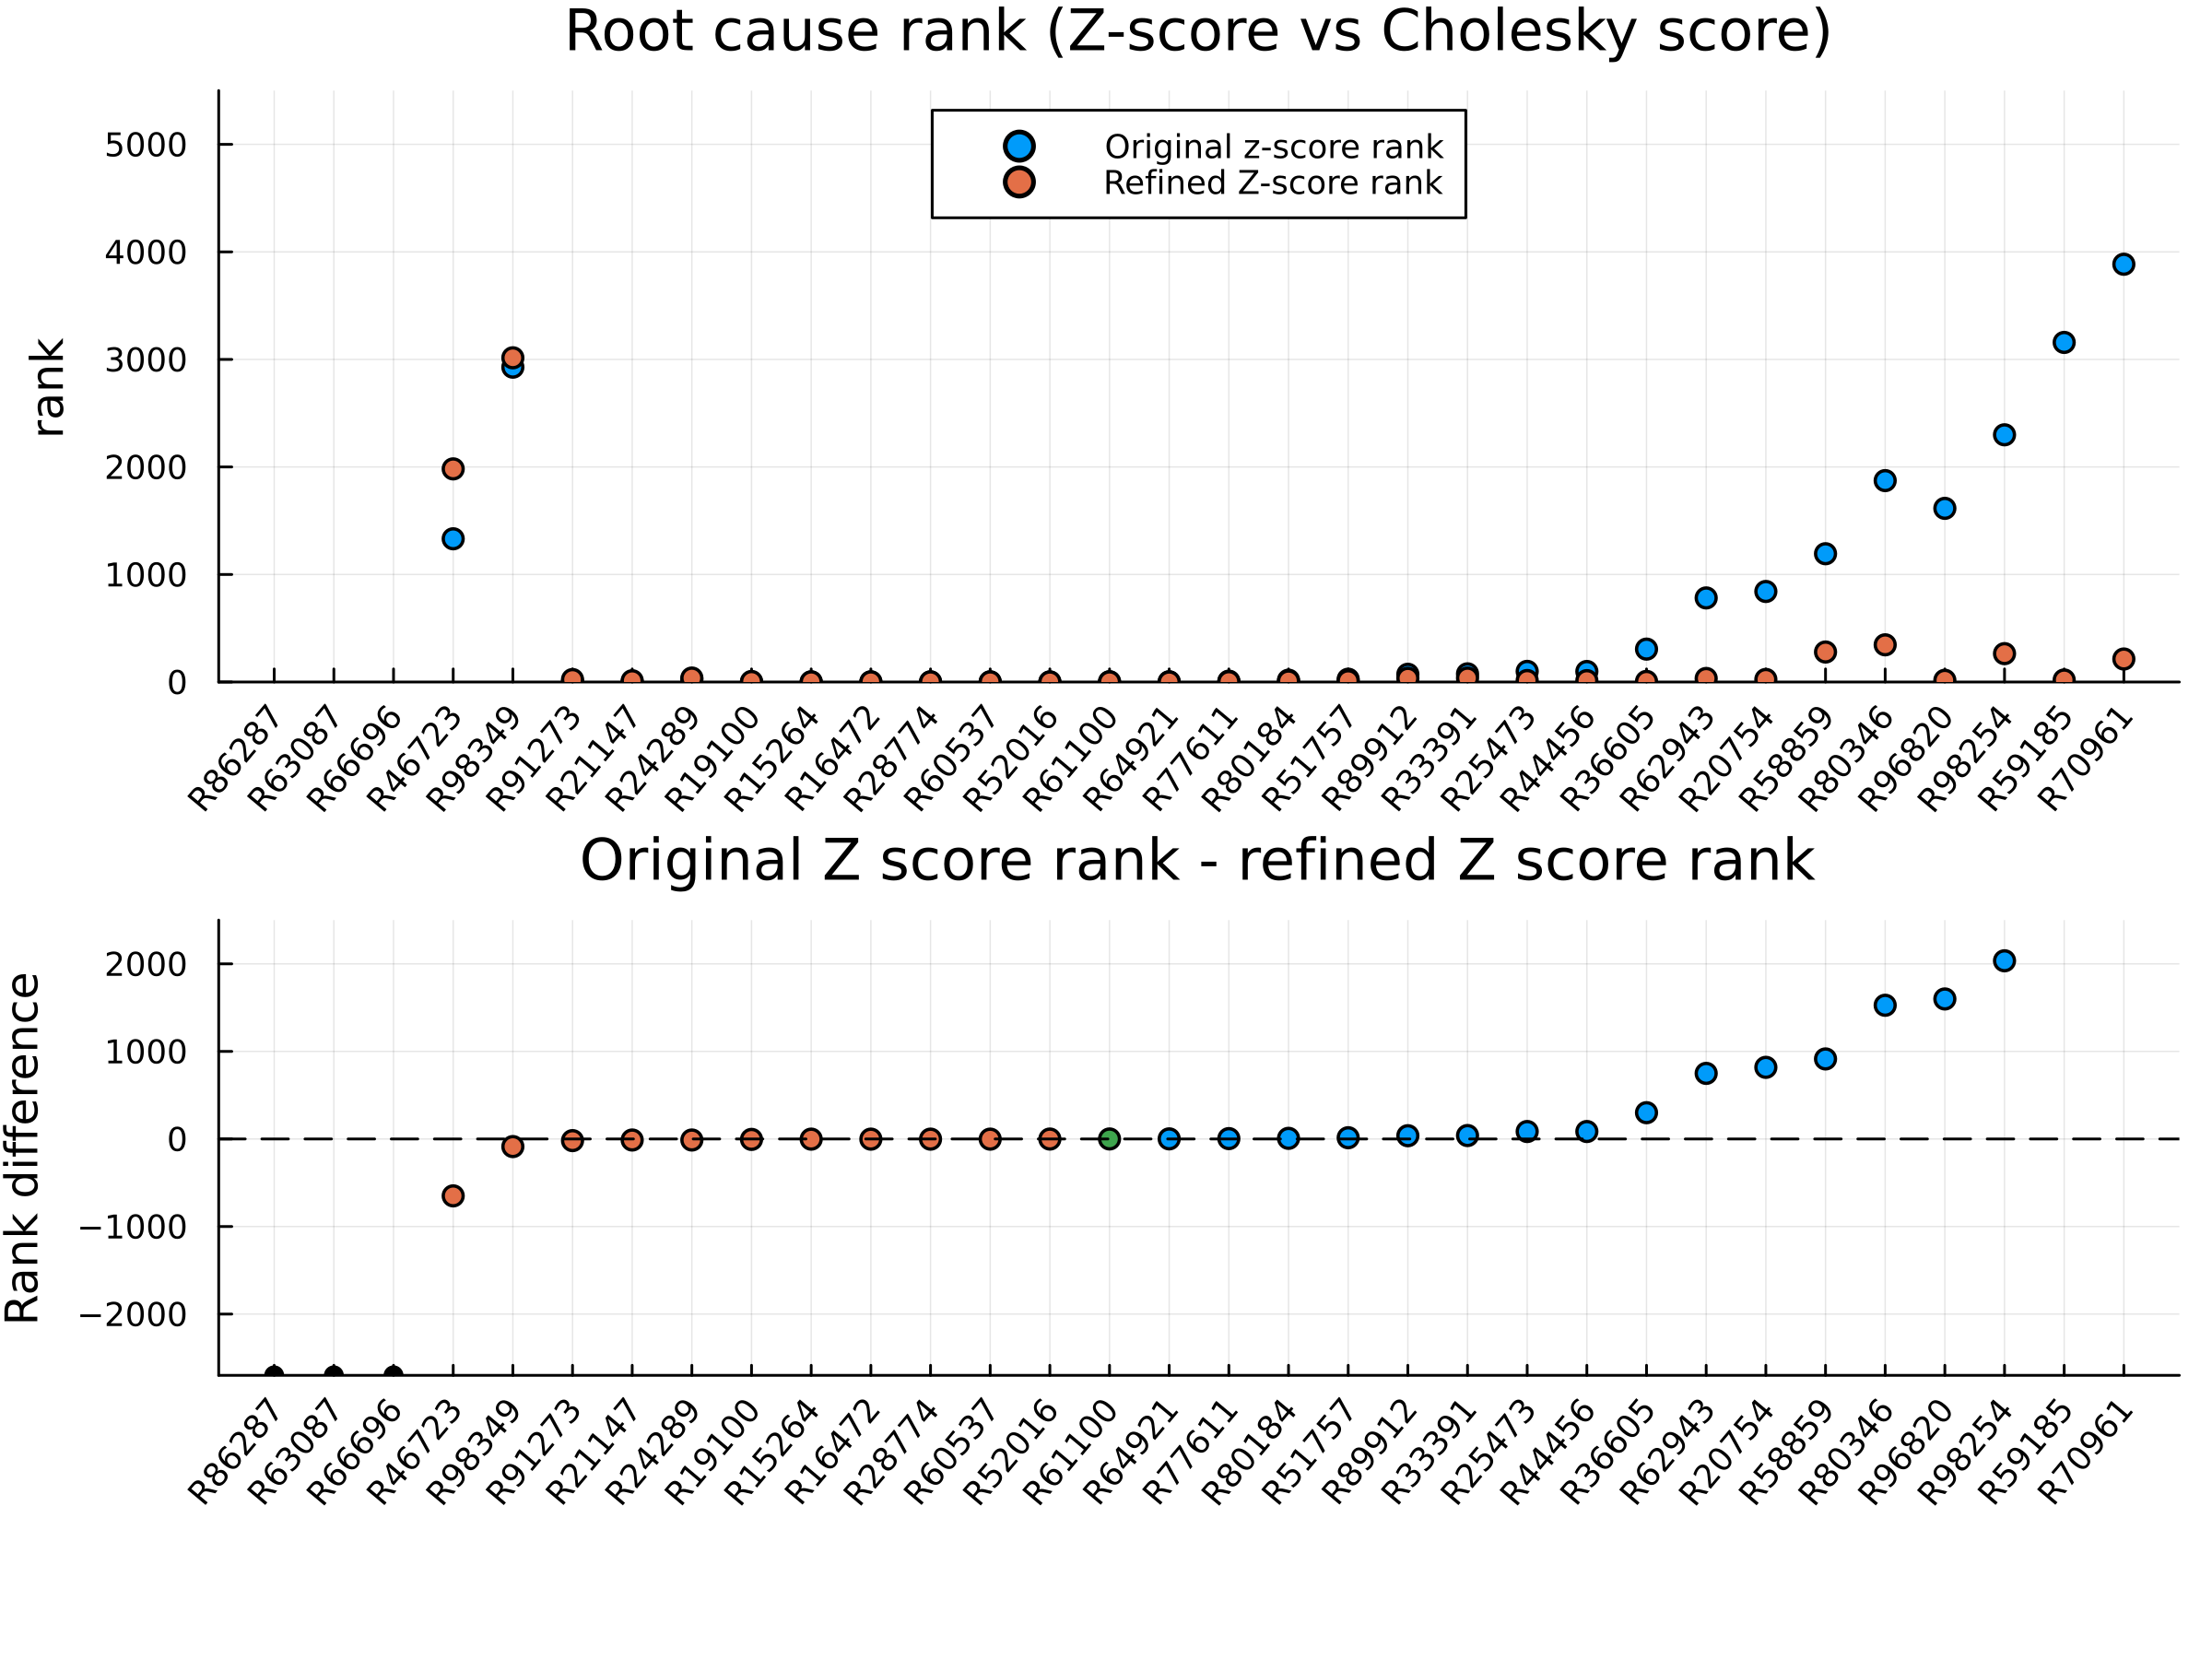

In [31]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

In [8]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.11.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = refine_z_score_rank(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:22


df = 32×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        782.0                 388.0
   2 │ R98254                       2299.0                 918.0
   3 │ R86287                      15417.0                 Inf
   4 │ R89912                         72.0                  61.0
   5 │ R19100                          0.0                   0.0
   6 │ R15264                          0.0                   0.0
   7 │ R36605                        306.0                 187.0
   8 │ R61100                          2.0                   2.0
   9 │ R77611                          8.0                   8.0
  10 │ R16472                          0.0                   0.0
  11 │ R51757                         26.0                  23.0
  12 │ R80346                       1873.0                 826.0
  13 │ R20754      

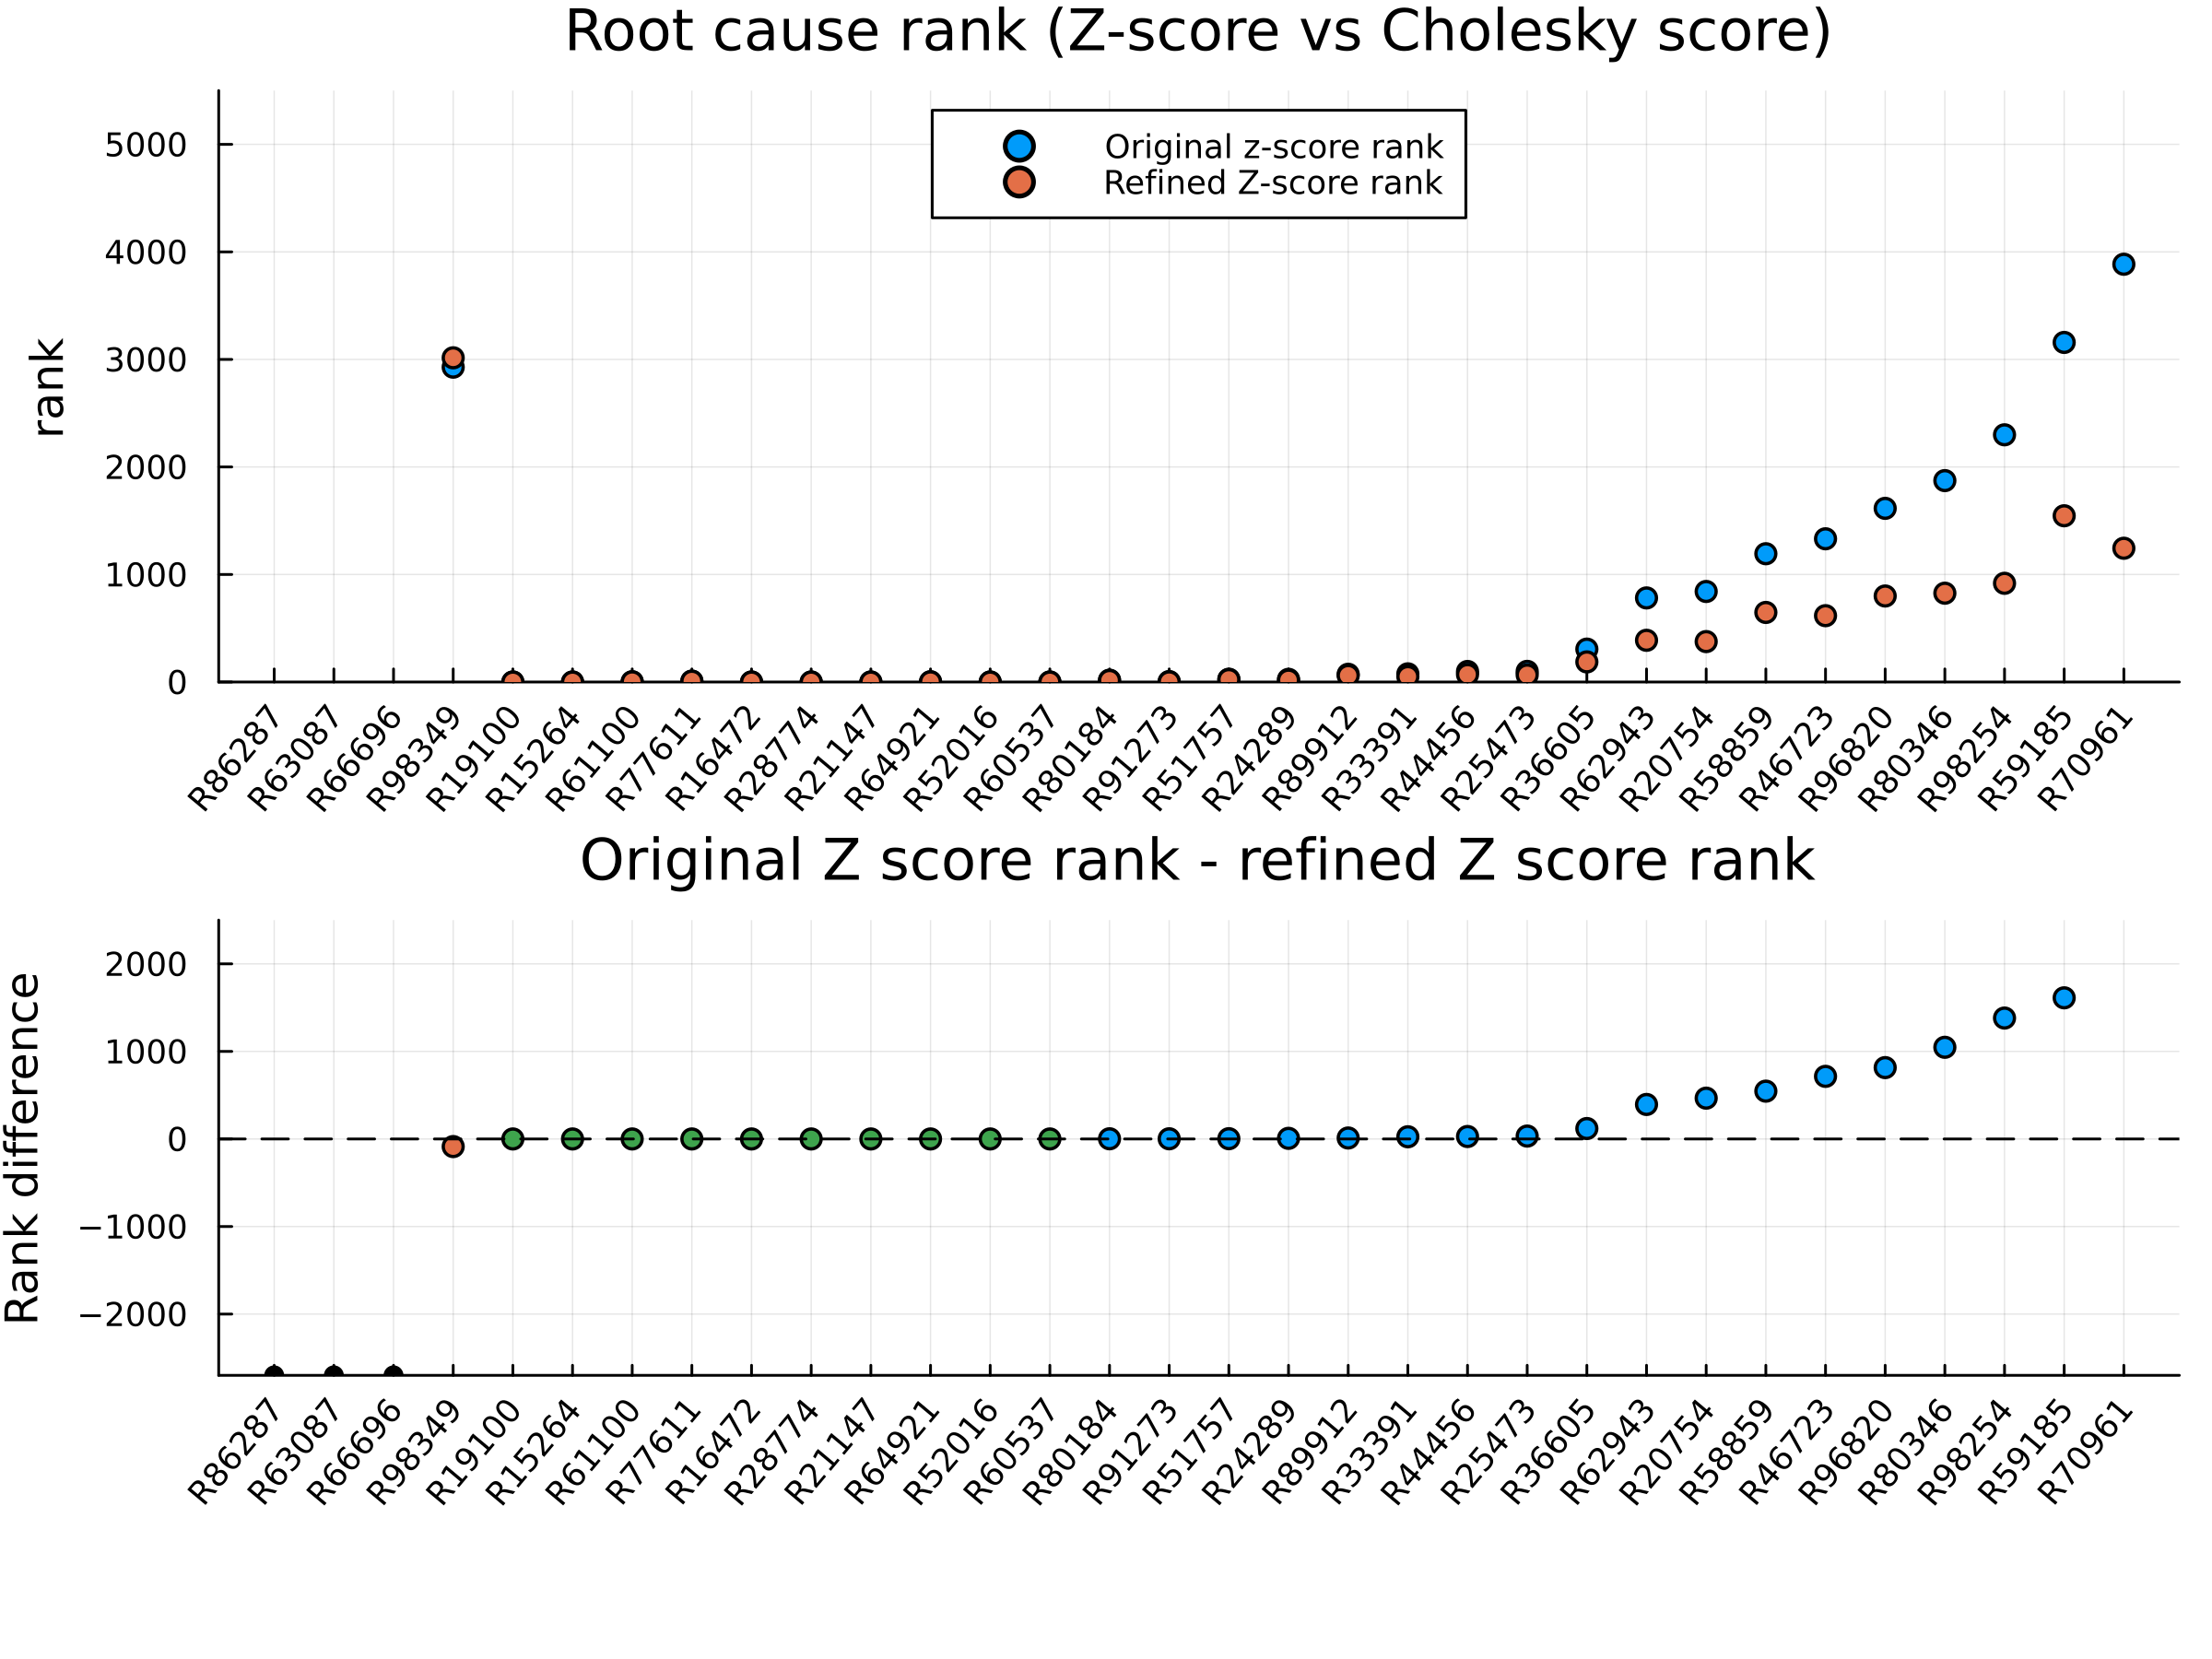

In [9]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 5.10.2024

+ low_count = 10
+ threshold = 0.05

In [4]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.10.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = refine_z_score_rank2(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress: 100%|█████████████████████████████████████████| Time: 0:04:04


df = 32×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        782.0                  31.0
   2 │ R98254                       2299.0                 246.0
   3 │ R86287                      15417.0                 Inf
   4 │ R89912                         72.0                  25.0
   5 │ R19100                          0.0                   5.0
   6 │ R15264                          0.0                   2.0
   7 │ R36605                        306.0                   5.0
   8 │ R61100                          2.0                   2.0
   9 │ R77611                          8.0                   4.0
  10 │ R16472                          0.0                   3.0
  11 │ R51757                         26.0                   6.0
  12 │ R80346                       1873.0                 312.0
  13 │ R20754      

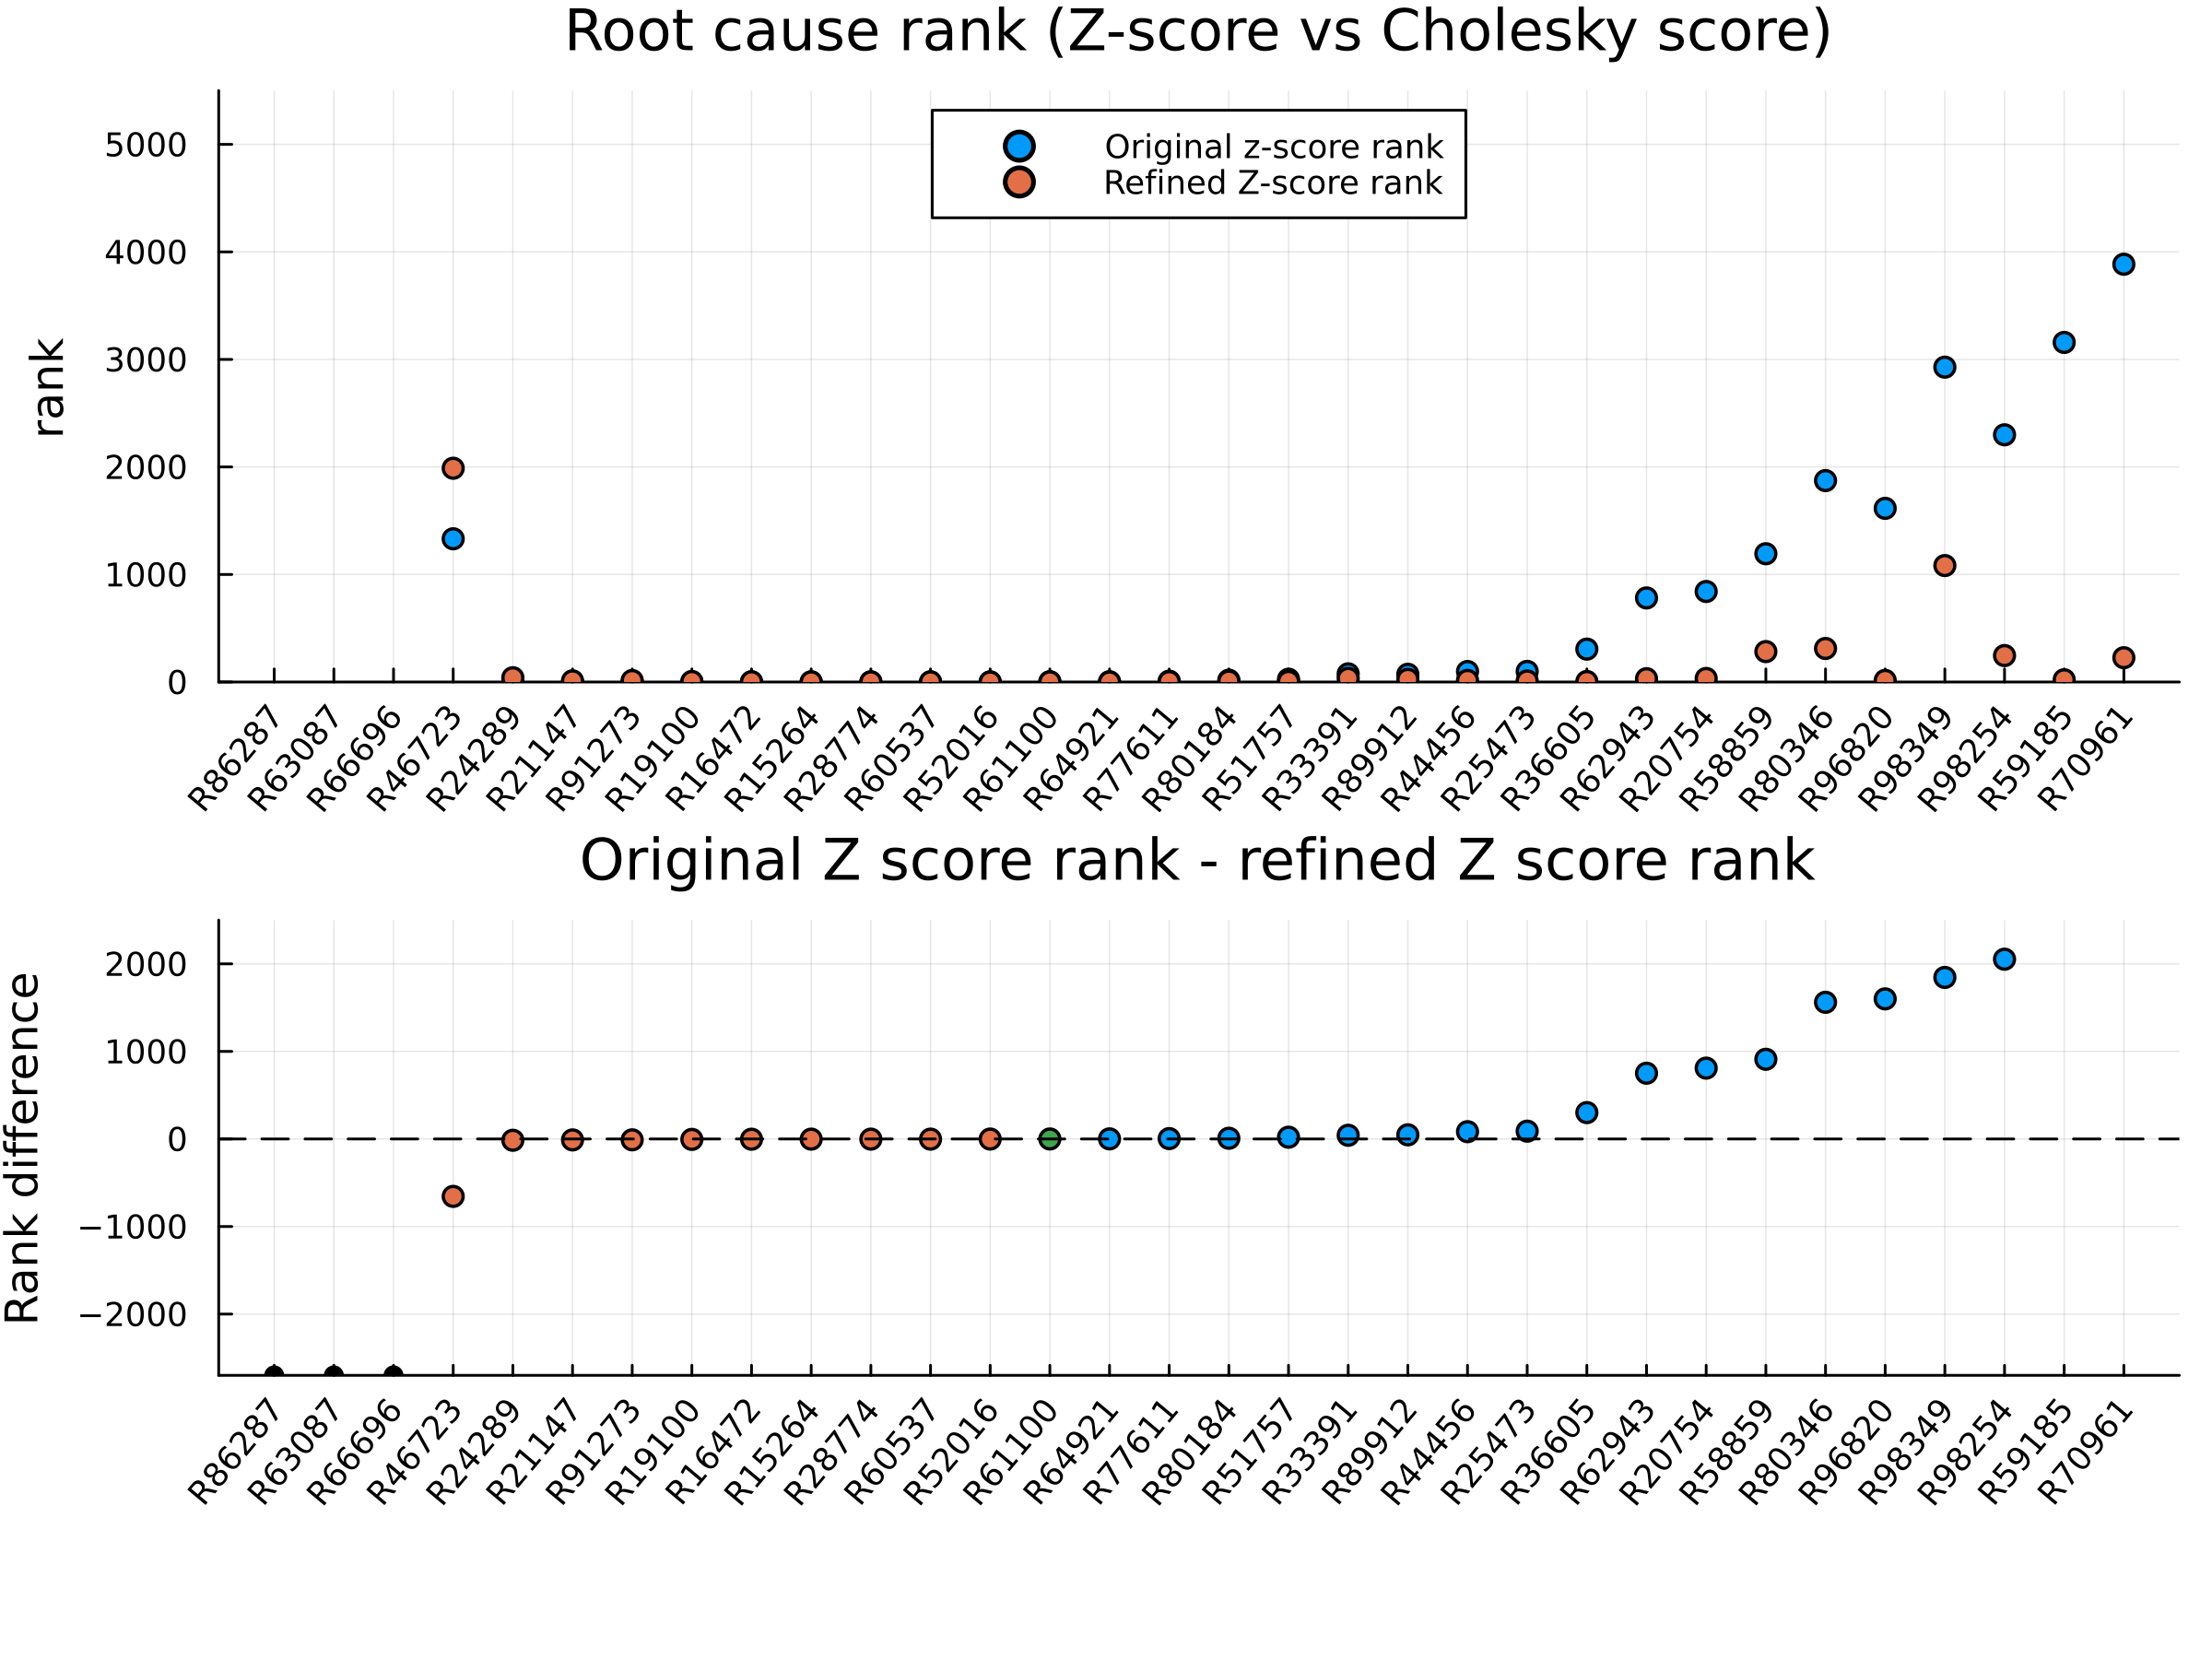

In [5]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

In [5]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.10.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = refine_z_score_rank(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


df = 32×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        782.0                 386.0
   2 │ R98254                       2299.0                 913.0
   3 │ R86287                      15417.0                 Inf
   4 │ R89912                         72.0                  62.0
   5 │ R19100                          0.0                   0.0
   6 │ R15264                          0.0                   0.0
   7 │ R36605                        306.0                 185.0
   8 │ R61100                          2.0                   2.0
   9 │ R77611                          8.0                   8.0
  10 │ R16472                          0.0                   0.0
  11 │ R51757                         26.0                  25.0
  12 │ R80346                       1873.0                 823.0
  13 │ R20754      

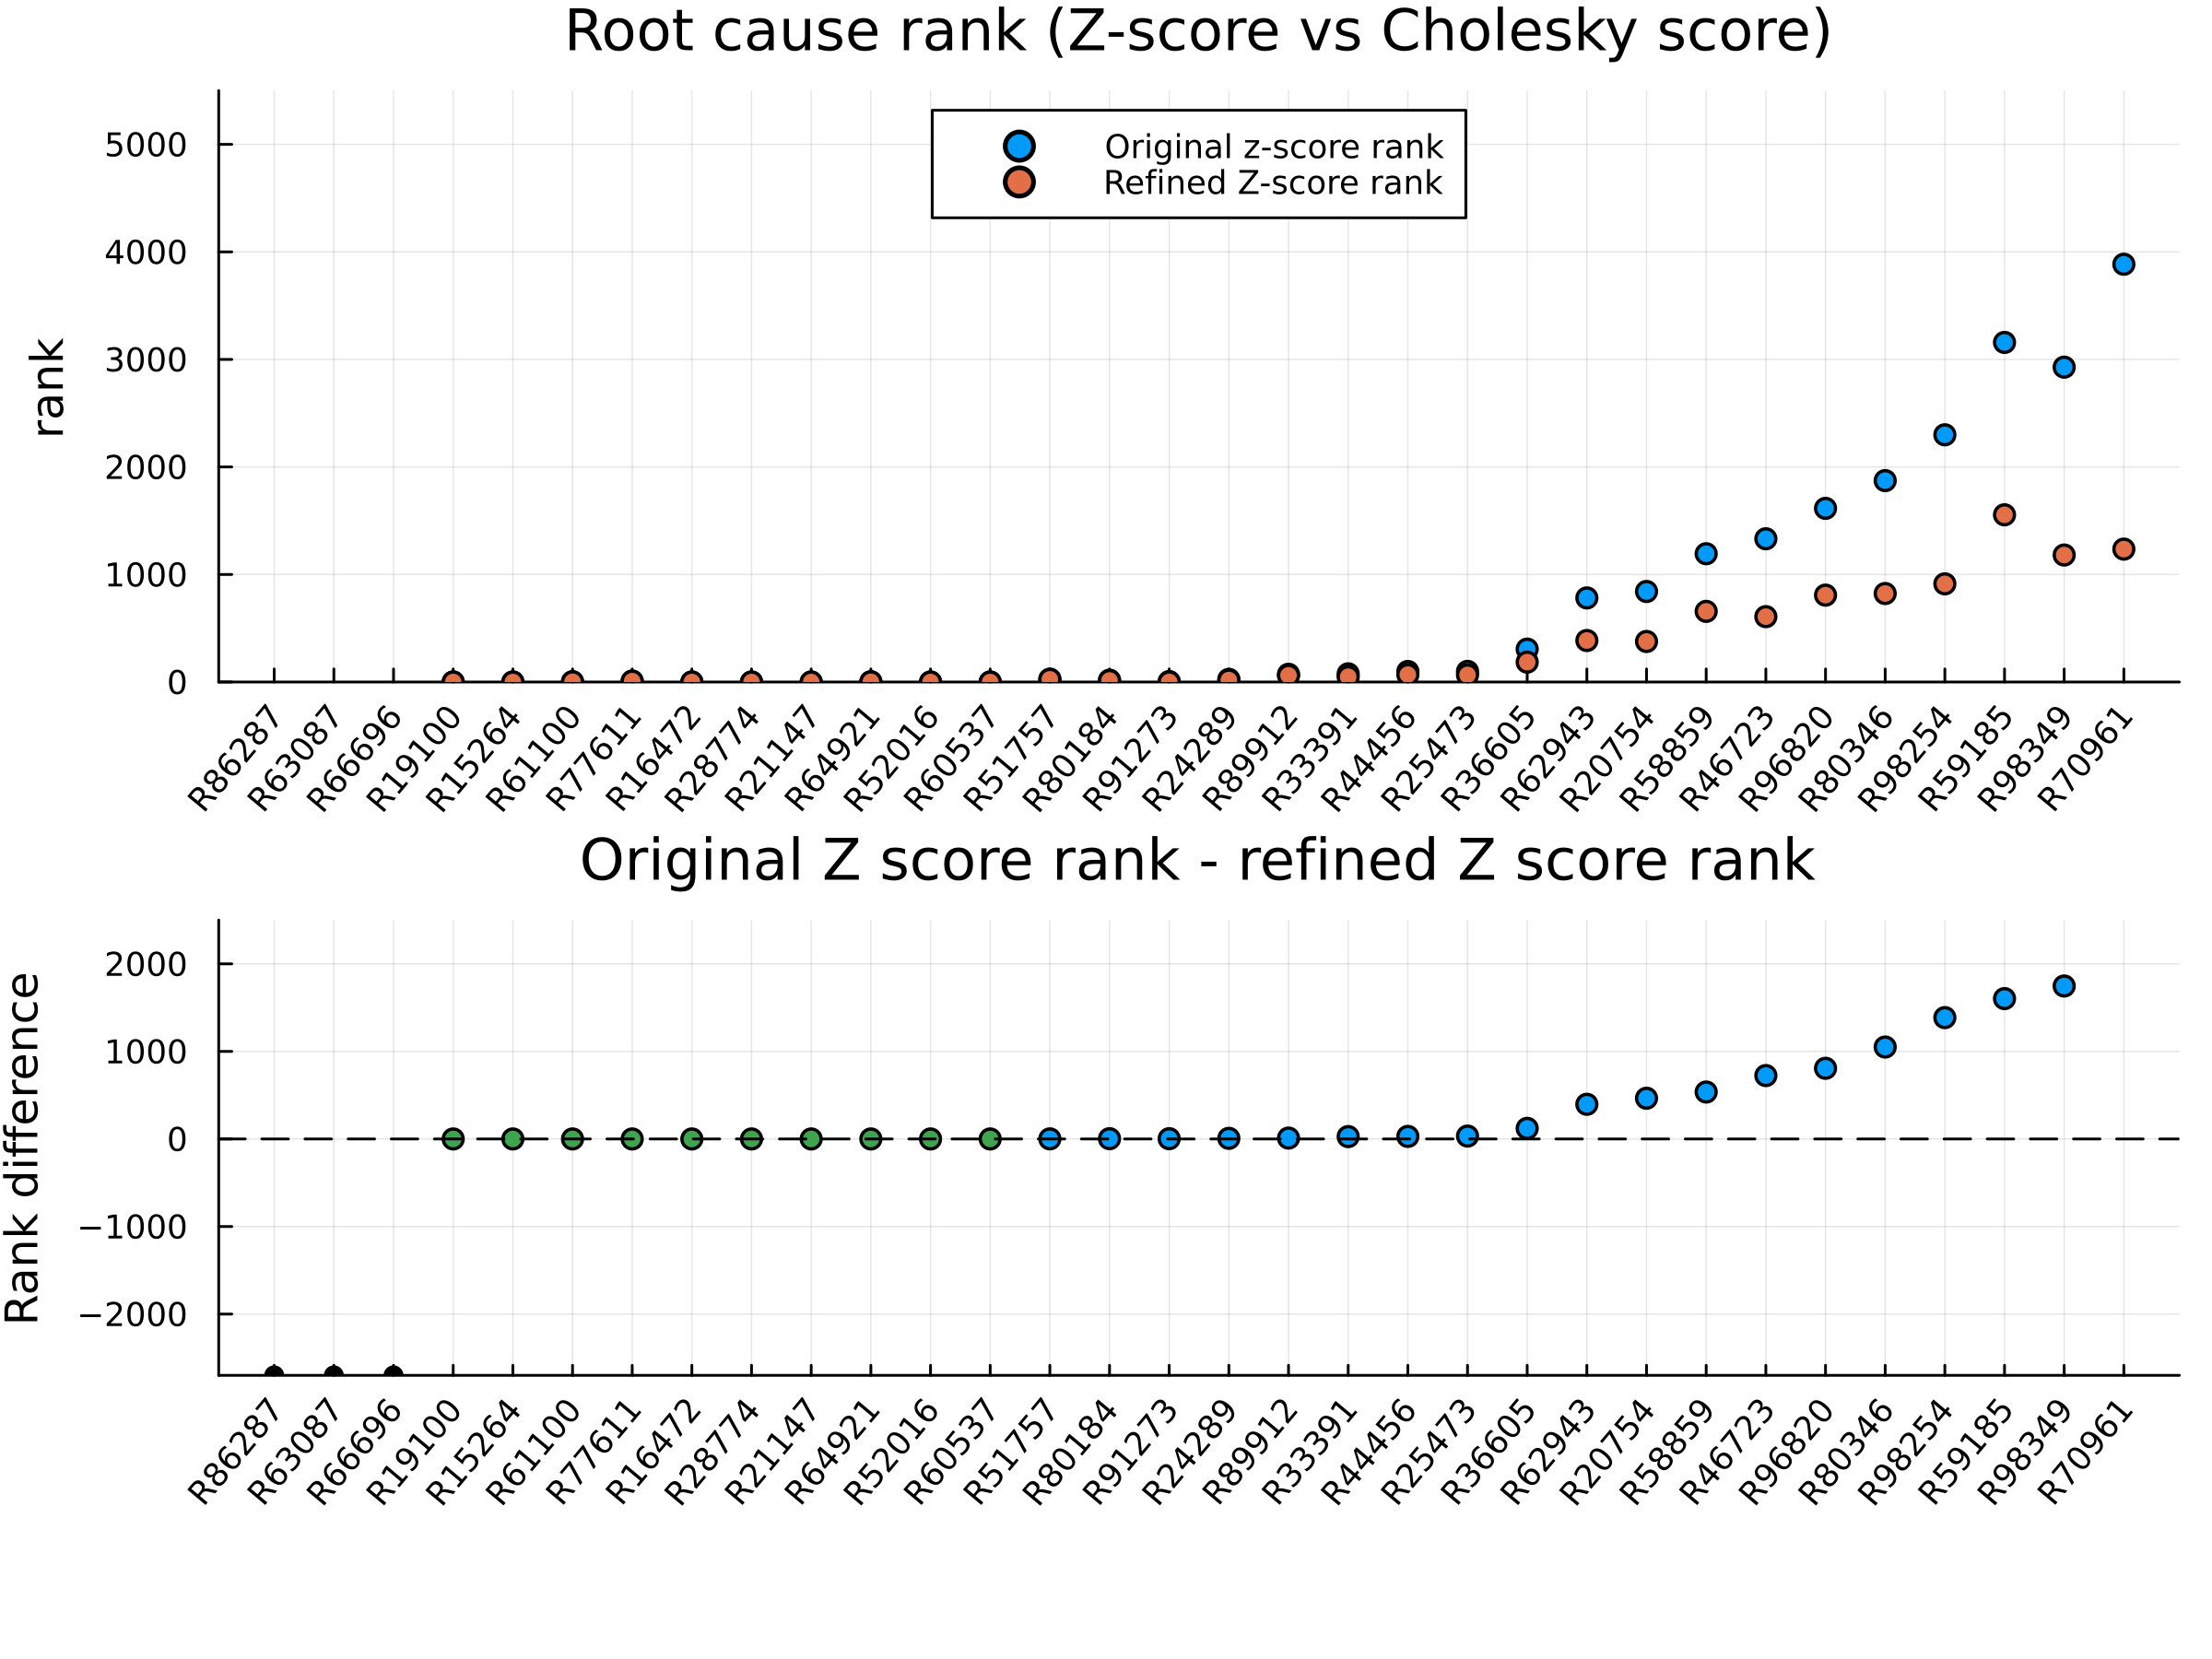

In [6]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 4.2.2024 CHECK THIS!!!

+ low_count = 10
+ threshold = 0.05

# *Warning* Results below had the permutation bug

### 5.1.2024

+ low_count = 5
+ threshold = 0.05

In [3]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.1.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = refine_z_score_rank(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:08

ArgumentError(

Progress: 100%|█████████████████████████████████████████| Time: 0:03:59


"No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.1.2024/largest_support/R70961.jld2")
df = 31×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        985.0                 415.0
   2 │ R98254                       2948.0                1891.0
   3 │ R86287                      17420.0                 Inf
   4 │ R89912                        107.0                  48.0
   5 │ R19100                          0.0                   0.0
   6 │ R15264                          0.0                   0.0
   7 │ R36605                        366.0                 163.0
   8 │ R61100                          5.0                   1.0
   9 │ R77611                         13.0                   2.0
  10 │ R16472                          0.0                   0.0
  11 │ R51757                         3

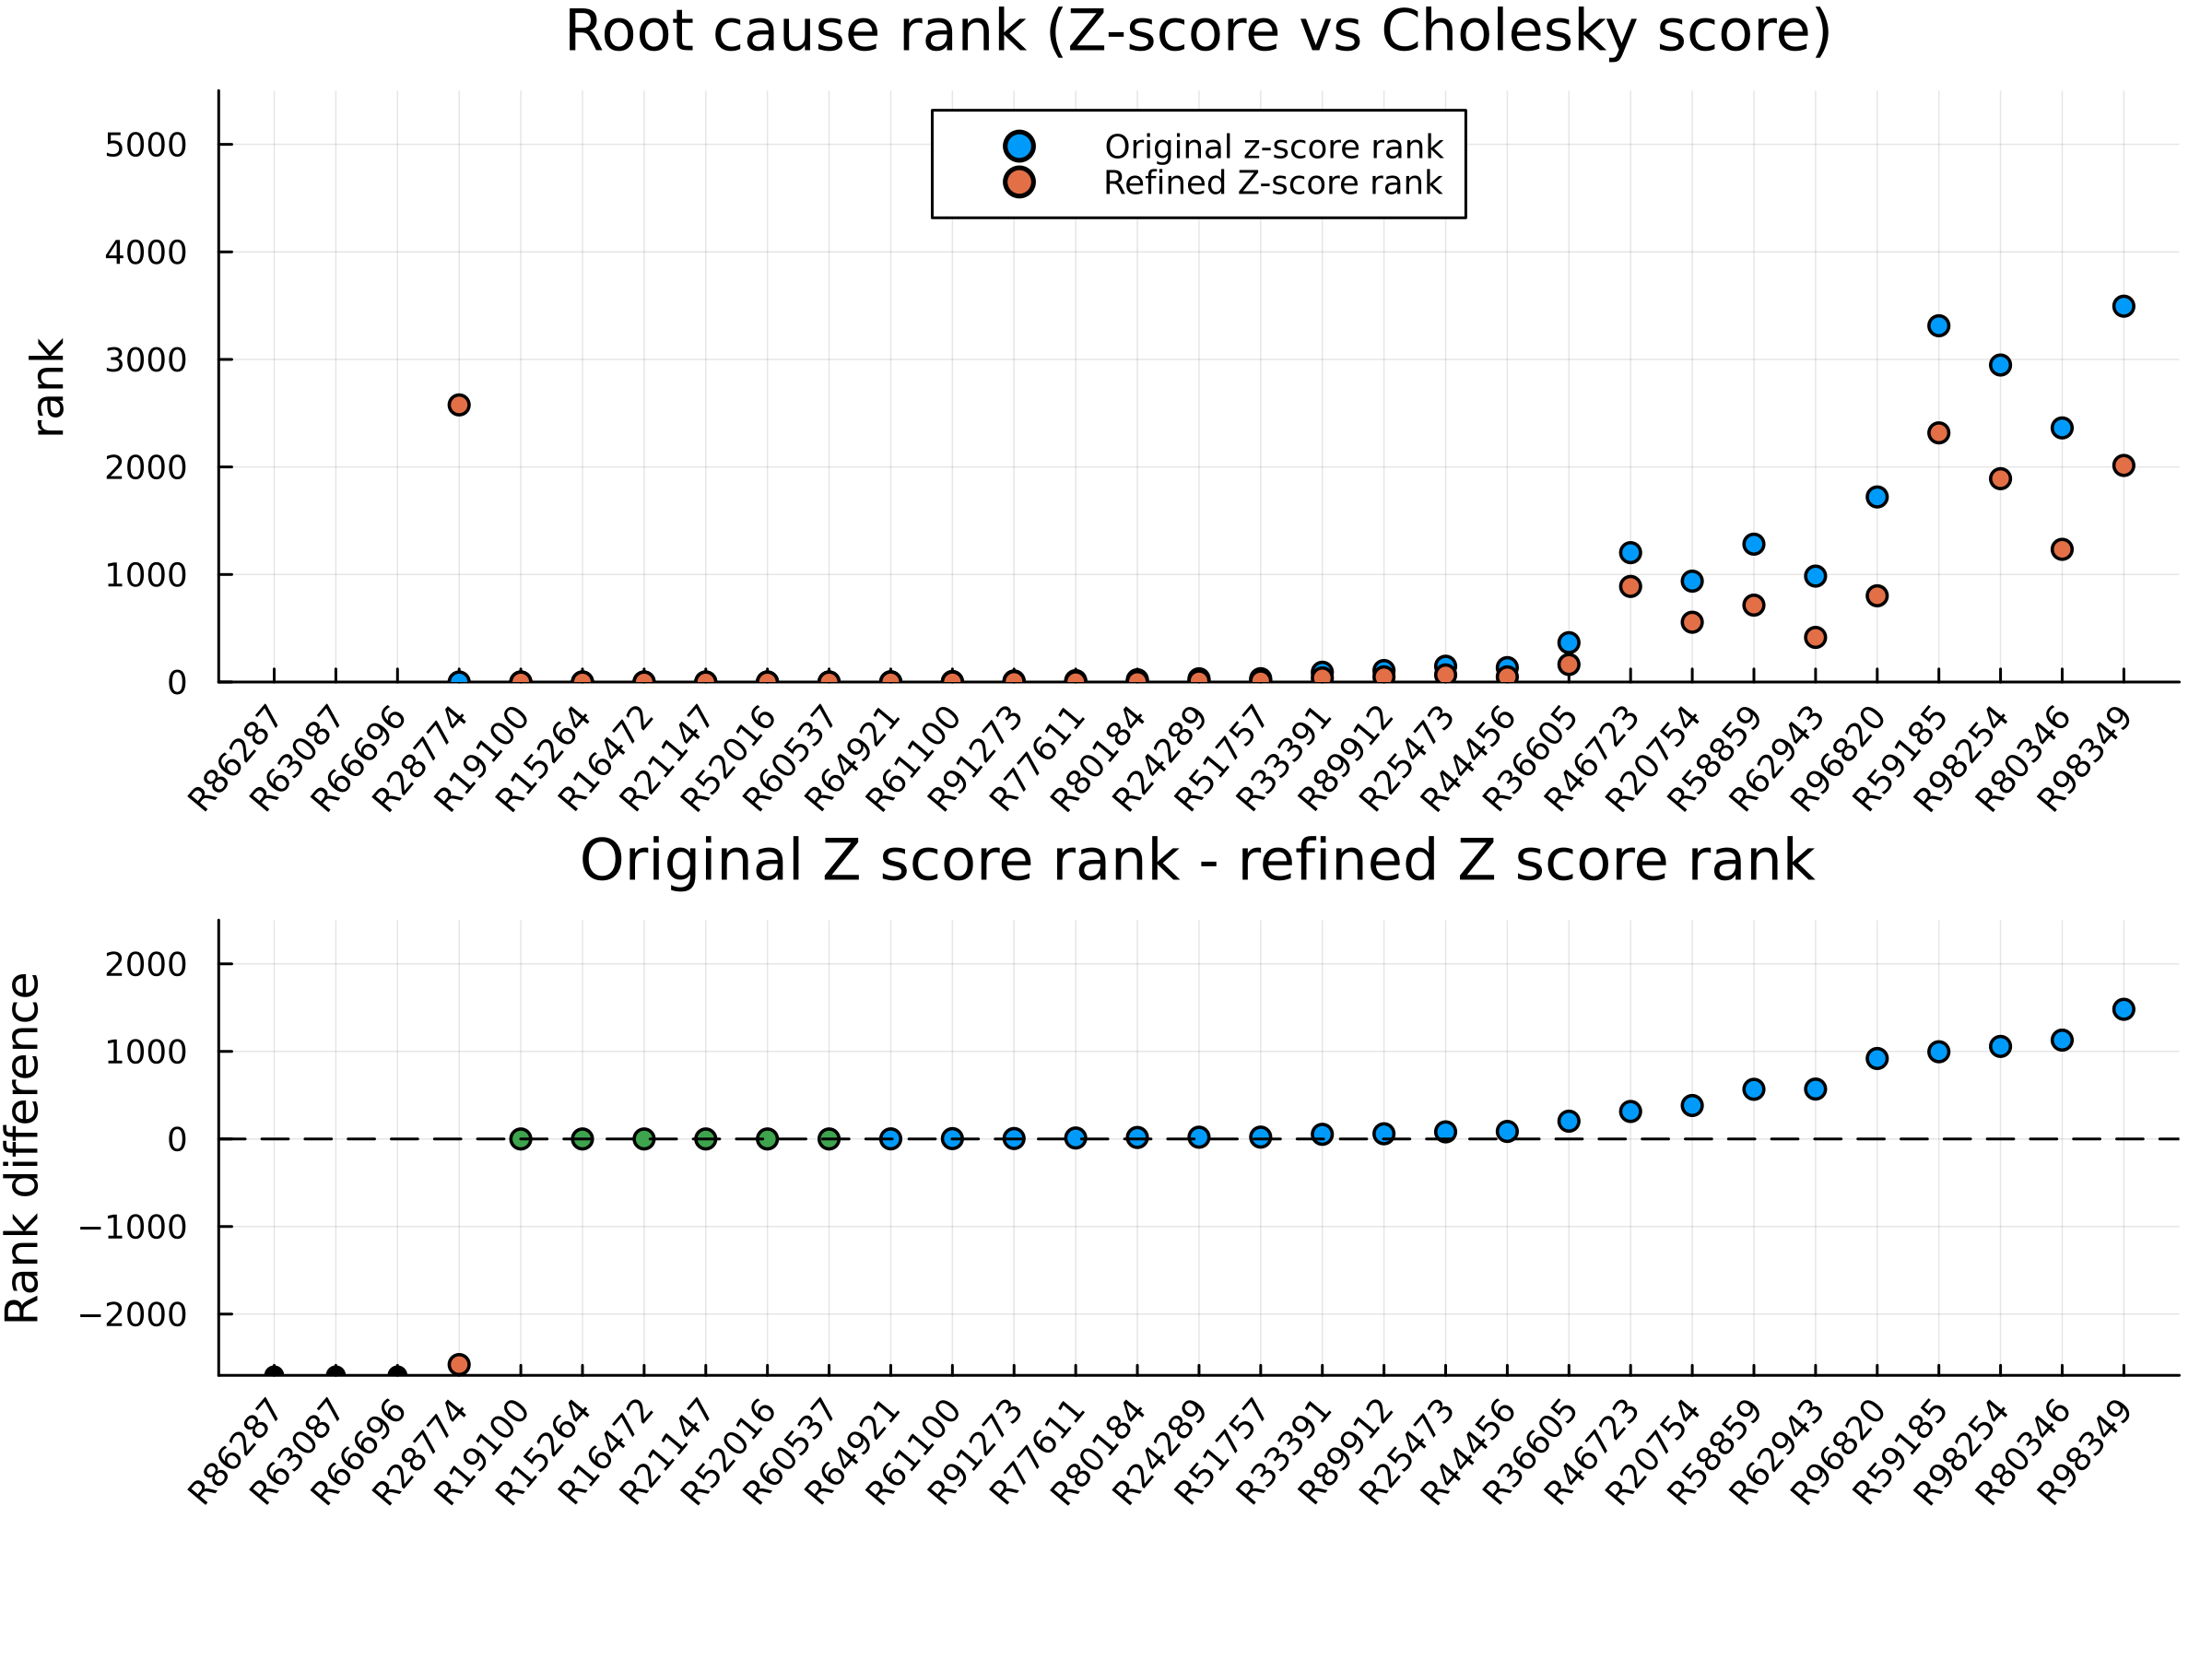

In [6]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)